# The Duration of Unemployment - Replicating Lalive et al. (2006, ReStud)

## 1. The contribution of this study

- The objectives: 
- How do they relate to the established literature?
- What is novel about the empirical strategy?
- What are the results and how convincing are these?

    By using longitudinal database combined from both Austrian social security and Austrian unemployement register database which ranges from 1 August 1987 until 31 July 1991 (4 years - including 2 years before and 2 years after the change of policy in unemployment insurance in Austria), 

RR - replacement rate
PBD - potential benefit duration
    A considerable theoretical literature has shown that more generous unemployment insurance system (through a higher RR and/or a longer PBD) will reduce the optimal job search effort of an unemployed worker and hence result in longer unemployment duration.
    Moreover the theories also offer sharp predictions on how changes in key parameters in unemployment insurance will affect the unemployment exit rate.
    The present paper identifies the causal effect of benefit duration on the willingness of individuals to accept jobs using a policy change that took place
    

## 2. Attempt to replicate Table 4 of the paper

In [4]:
# Data Preparation
rm(list=objects())

In [7]:
install.packages('ggplot2')

Installing package into 'C:/Users/hoang/Documents/R/win-library/3.5'
(as 'lib' is unspecified)
also installing the dependencies 'colorspace', 'stringr', 'labeling', 'munsell', 'RColorBrewer', 'gtable', 'lazyeval', 'plyr', 'reshape2', 'scales', 'viridisLite'



package 'colorspace' successfully unpacked and MD5 sums checked
package 'stringr' successfully unpacked and MD5 sums checked
package 'labeling' successfully unpacked and MD5 sums checked
package 'munsell' successfully unpacked and MD5 sums checked
package 'RColorBrewer' successfully unpacked and MD5 sums checked
package 'gtable' successfully unpacked and MD5 sums checked
package 'lazyeval' successfully unpacked and MD5 sums checked
package 'plyr' successfully unpacked and MD5 sums checked
package 'reshape2' successfully unpacked and MD5 sums checked
package 'scales' successfully unpacked and MD5 sums checked
package 'viridisLite' successfully unpacked and MD5 sums checked
package 'ggplot2' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\hoang\AppData\Local\Temp\RtmpmUlXOR\downloaded_packages


In [8]:
# Loading some necessary packages
library(foreign)
library(survival)
library(dplyr)
library(tidyr)
library(KernSmooth)
library(ggplot2)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

KernSmooth 2.23 loaded
Copyright M. P. Wand 1997-2009


In [9]:
# Loading the dataset
udat <- read.dta("fi.dta")

In [10]:
# Checking the dimension
print(dim(udat))

[1] 225821    166


In [11]:
# Getting rid of some superfluous variables
udat <- udat[,1:134]

In [12]:
# Checking the quantity of four groups of unemployed workers
table(udat$type)


PBD and RR        PBD         RR    control 
     21174      99404      32470      72773 

In [13]:
# Computation of average spells when durations are truncated at 104 weeks
udat$dur104 <- udat$dur
udat$dur104[(udat$dur104 > 104)] = 104

## Question 2

In [14]:
table4 <- udat %>%
    mutate(Type = ifelse(type == 'PBD', 'ePBD group', ifelse(type == 'RR', 'eRR group', ifelse(type == 'PBD and RR', 'ePBD-RR group', 'Control group')))) %>%
    group_by(Type, after) %>%
    summarize(average = mean(dur104), standard_deviation = sd(dur104), count = n()) %>%
    mutate(standard_error = standard_deviation / sqrt(count))

In [15]:
table4

Type,after,average,standard_deviation,count,standard_error
Control group,0,14.46226,14.38562,33815,0.07823008
Control group,1,15.63168,17.16584,38958,0.08696947
ePBD-RR group,0,18.48832,17.71669,11992,0.16178444
ePBD-RR group,1,22.73973,22.32690,9182,0.23300208
ePBD group,0,15.83402,16.64017,48294,0.07572010
ePBD group,1,18.08298,20.61513,51110,0.09118705
eRR group,0,17.10815,15.45186,17160,0.11795657
eRR group,1,19.09596,18.83882,15310,0.15225308


In [16]:
avg_table4 <- table4 %>%
    select(Type, after, average) %>%
    spread(after, average) %>%
    mutate(Value = 'average') %>%
    rename(Before_August_1989 = '0', After_August_1989 = '1') %>%
    mutate(Change_After_Before = After_August_1989 - Before_August_1989) %>%
    mutate(Diff_in_diff = Change_After_Before - 1.17) %>%
    mutate_if(is.numeric, round, 2)
avg_table4$Position = c(4, 3, 1, 2)

In [17]:
ste_table4 <- table4 %>%
    select(Type, after, standard_error) %>%
    spread(after, standard_error) %>%
    mutate(Value = 'ste') %>%
    rename(Before_August_1989 = '0', After_August_1989 = '1') %>%
    mutate(Change_After_Before = sqrt(After_August_1989**2 + Before_August_1989**2)) %>%
    mutate(Diff_in_diff = sqrt(Change_After_Before**2 + 0.12**2)) %>%
    mutate_if(is.numeric, round, 2)
ste_table4$Position = c(4, 3, 1, 2)

In [18]:
count_table4 <- table4 %>%
    select(Type, after, count) %>%
    spread(after, count) %>%
    mutate(Value = 'count') %>%
    rename(Before_August_1989 = '0', After_August_1989 = '1') %>%
    mutate_if(is.numeric, round, 0)
count_table4$Position = c(4, 3, 1, 2)

In [19]:
table4_final <- bind_rows(avg_table4, ste_table4, count_table4)

In [20]:
table4_final <- table4_final %>%
    arrange(Position) %>%
    select(Type, Value, Before_August_1989, After_August_1989, Change_After_Before, Diff_in_diff)

In [21]:
table4_final$Diff_in_diff[table4_final$Type == 'Control group'] = NA

In [22]:
table4_final

Type,Value,Before_August_1989,After_August_1989,Change_After_Before,Diff_in_diff
ePBD group,average,15.83,18.08,2.25,1.08
ePBD group,ste,0.08,0.09,0.12,0.17
ePBD group,count,48294.00,51110.00,NA,NA
eRR group,average,17.11,19.10,1.99,0.82
eRR group,ste,0.12,0.15,0.19,0.23
eRR group,count,17160.00,15310.00,NA,NA
ePBD-RR group,average,18.49,22.74,4.25,3.08
ePBD-RR group,ste,0.16,0.23,0.28,0.31
ePBD-RR group,count,11992.00,9182.00,NA,NA
Control group,average,14.46,15.63,1.17,NA


## 3. Seek to reproduce Figure 3 in Lalive et al. (2006)

In [23]:
PBD_before <- udat %>%
    filter(after == 0, type == 'PBD') %>%
    select(dur104, uncc)
PBD_after <- udat %>%
    filter(after == 1, type == 'PBD') %>%
    select(dur104, uncc)
RR_before <- udat %>%
    filter(after == 0, type == 'RR') %>%
    select(dur104, uncc)
RR_after <- udat %>%
    filter(after == 1, type == 'RR') %>%
    select(dur104, uncc)
PBD_RR_before <- udat %>%
    filter(after == 0, type == 'PBD and RR') %>%
    select(dur104, uncc)
PBD_RR_after <- udat %>%
    filter(after == 1, type == 'PBD and RR') %>%
    select(dur104, uncc)
control_before <- udat %>%
    filter(after == 0, type == 'control') %>%
    select(dur104, uncc)
control_after <- udat %>%
    filter(after == 1, type == 'control') %>%
    select(dur104, uncc)

In [24]:
surv_PBD_before <- Surv(PBD_before$dur104, PBD_before$uncc)
surv_PBD_after <- Surv(PBD_after$dur104, PBD_after$uncc)

surv_RR_before <- Surv(RR_before$dur104, RR_before$uncc)
surv_RR_after <- Surv(RR_after$dur104, RR_after$uncc)

surv_PBD_RR_before <- Surv(PBD_RR_before$dur104, PBD_RR_before$uncc)
surv_PBD_RR_after <- Surv(PBD_RR_after$dur104, PBD_RR_after$uncc)

surv_control_before <- Surv(control_before$dur104, control_before$uncc)
surv_control_after <- Surv(control_after$dur104, control_after$uncc)

In [25]:
surv_PBD_before.fit <- survfit(surv_PBD_before ~ 1)
surv_PBD_after.fit <- survfit(surv_PBD_after ~ 1)

surv_RR_before.fit <- survfit(surv_RR_before ~ 1)
surv_RR_after.fit <- survfit(surv_RR_after ~ 1)

surv_PBD_RR_before.fit <- survfit(surv_PBD_RR_before ~ 1)
surv_PBD_RR_after.fit <- survfit(surv_PBD_RR_after ~ 1)

surv_control_before.fit <- survfit(surv_control_before ~ 1)
surv_control_after.fit <- survfit(surv_control_after ~ 1)

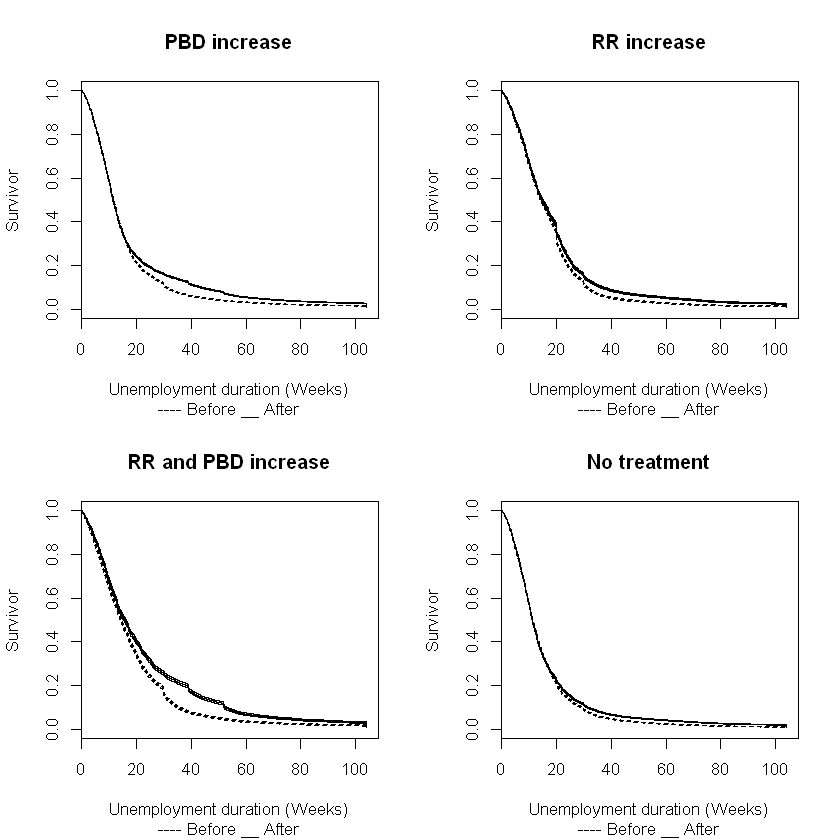

In [27]:
par(mfrow = c(2, 2))
plot(surv_PBD_before.fit, lty = "dashed", main="PBD increase", xlab="Unemployment duration (Weeks)", ylab="Survivor", sub = "---- Before __ After")
par(new=TRUE)
plot(surv_PBD_after.fit, lty = "solid", lwd = 1, xlab="Unemployment duration (Weeks)", ylab="Survivor")

plot(surv_RR_before.fit, lty = "dashed", main="RR increase", xlab="Unemployment duration (Weeks)", ylab="Survivor", sub = "---- Before __ After")
par(new=TRUE)
plot(surv_RR_after.fit, lty = "solid", lwd = 1, xlab="Unemployment duration (Weeks)", ylab="Survivor")

plot(surv_PBD_RR_before.fit, lty = "dashed", main="RR and PBD increase", xlab="Unemployment duration (Weeks)", ylab="Survivor", sub = "---- Before __ After")
par(new=TRUE)
plot(surv_PBD_RR_after.fit, lty = "solid", lwd = 0.5, xlab="Unemployment duration (Weeks)", ylab="Survivor")

plot(surv_control_before.fit, lty = "dashed", main="No treatment", xlab="Unemployment duration (Weeks)", ylab="Survivor", sub = "---- Before __ After")
par(new=TRUE)
plot(surv_control_after.fit, lty = "solid", lwd = 1, xlab="Unemployment duration (Weeks)", ylab="Survivor")

In [419]:
png('Survivor.png')
par(mfrow = c(2, 2))
plot(surv_PBD_before.fit, lty = "dashed", main="PBD increase", xlab="Unemployment duration (Weeks)", ylab="Survivor", sub = "---- Before __ After")
par(new=TRUE)
plot(surv_PBD_after.fit, lty = "solid", lwd = 1, xlab="Unemployment duration (Weeks)", ylab="Survivor")

plot(surv_RR_before.fit, lty = "dashed", main="RR increase", xlab="Unemployment duration (Weeks)", ylab="Survivor", sub = "---- Before __ After")
par(new=TRUE)
plot(surv_RR_after.fit, lty = "solid", lwd = 1, xlab="Unemployment duration (Weeks)", ylab="Survivor")

plot(surv_PBD_RR_before.fit, lty = "dashed", main="RR and PBD increase", xlab="Unemployment duration (Weeks)", ylab="Survivor", sub = "---- Before __ After")
par(new=TRUE)
plot(surv_PBD_RR_after.fit, lty = "solid", lwd = 0.5, xlab="Unemployment duration (Weeks)", ylab="Survivor")

plot(surv_control_before.fit, lty = "dashed", main="No treatment", xlab="Unemployment duration (Weeks)", ylab="Survivor", sub = "---- Before __ After")
par(new=TRUE)
plot(surv_control_after.fit, lty = "solid", lwd = 1, xlab="Unemployment duration (Weeks)", ylab="Survivor")
dev.off()

png 
  2

## 4. Seek to reproduce Figure 3 in Lalive et al. (2006)

In [24]:
hist_surv = list(summary(surv_PBD_before.fit)$surv, summary(surv_PBD_after.fit)$surv, summary(surv_RR_before.fit)$surv, 
                 summary(surv_RR_after.fit)$surv, summary(surv_PBD_RR_before.fit)$surv, summary(surv_PBD_RR_after.fit)$surv, 
                 summary(surv_control_before.fit)$surv, summary(surv_control_after.fit)$surv)

In [25]:
hist_dur = list(summary(surv_PBD_before.fit)$time, summary(surv_PBD_after.fit)$time, summary(surv_RR_before.fit)$time, 
                 summary(surv_RR_after.fit)$time, summary(surv_PBD_RR_before.fit)$time, summary(surv_PBD_RR_after.fit)$time, 
                 summary(surv_control_before.fit)$time, summary(surv_control_after.fit)$time)

In [26]:
hazard = list()
local_regress = list()

In [27]:
for (i in (1:length(hist_surv))) {
    S = hist_surv[[i]]
    t = hist_dur[[i]]
    F = 1 - S
    weeks = seq(1, length(t), length.out = 104)
    S_week = S[weeks]
    F_week = F[weeks]
    t_week = t[weeks]
    f_week = (F_week[2:104] - F_week[1:103])/(t_week[2:104] - t_week[1:103])
    lambda = f_week[1:102]/S_week[1:102]
    hazard[[i]] <- lambda
    local_regress[[i]] <- locpoly(c(1:102), lambda, bandwidth = 2)
}

In [411]:
png('Hazard_PBD_before.png')
plot(hazard[[1]], type = 'l', lty = "dashed", main="PBD increase, before August 1989", ylim = c(0, 0.15), xlab="Unemployment duration (Weeks)", ylab="Hazard")
par(new = TRUE)
lines(local_regress[[1]], col = 'red')
dev.off()

png 
  2

In [412]:
png('Hazard_PBD_after.png')
plot(hazard[[2]], type = 'l', lty = "dashed", main="PBD increase, after August 1989", ylim = c(0, 0.15), xlab="Unemployment duration (Weeks)", ylab="Hazard")
par(new = TRUE)
lines(local_regress[[2]], col = 'red')
dev.off()

png 
  2

In [413]:
png('Hazard_RR_before.png')
plot(hazard[[3]], type = 'l', lty = "dashed", main="RR increase, before August 1989", ylim = c(0, 0.15), xlab="Unemployment duration (Weeks)", ylab="Hazard")
par(new = TRUE)
lines(local_regress[[3]], col = 'red')
dev.off()

png 
  2

In [414]:
png('Hazard_RR_after.png')
plot(hazard[[4]], type = 'l', lty = "dashed", main="RR increase, after August 1989", ylim = c(0, 0.15), xlab="Unemployment duration (Weeks)", ylab="Hazard")
par(new = TRUE)
lines(local_regress[[4]], col = 'red')
dev.off()

png 
  2

In [415]:
png('Hazard_RR_PBD_before.png')
plot(hazard[[5]], type = 'l', lty = "dashed", main="RR and PBD increase, before August 1989", ylim = c(0, 0.15), xlab="Unemployment duration (Weeks)", ylab="Hazard")
par(new = TRUE)
lines(local_regress[[5]], col = 'red')
dev.off()

png 
  2

In [416]:
png('Hazard_RR_PBD_after.png')
plot(hazard[[6]], type = 'l', lty = "dashed", main="RR and PBD increase, after August 1989", ylim = c(0, 0.15), xlab="Unemployment duration (Weeks)", ylab="Hazard")
par(new = TRUE)
lines(local_regress[[6]], col = 'red')
dev.off()

png 
  2

In [417]:
png('No_treatment_before.png')
plot(hazard[[7]], type = 'l', lty = "dashed", main="No treatment, before August 1989", ylim = c(0, 0.15), xlab="Unemployment duration (Weeks)", ylab="Hazard")
par(new = TRUE)
lines(local_regress[[7]], col = 'red')
dev.off()

png 
  2

In [418]:
png('No_treatment_after.png')
plot(hazard[[8]], type = 'l', lty = "dashed", main="No treatment, after August 1989", ylim = c(0, 0.15), xlab="Unemployment duration (Weeks)", ylab="Hazard")
par(new = TRUE)
lines(local_regress[[8]], col = 'red')
dev.off()

png 
  2

## 5. Estimate the causal treatment effect in a PH model

- dur: duration of unemployment spell (weeks)
- bdur:  potential benefit duration (weeks)
- uncc =1: if spell not censored
- tr =1 if replacement rate change
- t39 = 1 if PBD 30-39 change
- t52 = 1 if PBD 30-52 change
- t39_tr = t39 * tr
- t52_tr = t52 * tr
- tr_a0 = tr * after0
- t39_a0 = t39 * after0
- t52_a0 = t52 * after0
- t39tra0 = t39 * tr * after0
- t52tra0 = t52 * tr * after0
- after = 1 if spell starts after Aug 1, 1989
- after0 = 1 if interval 0 after Aug 1, 1989

In [28]:
udat$all <- udat$tr * (udat$t39 + udat$t52)

In [29]:
breaks <- seq(from=3,to=59, by=4)

In [30]:
labels <- paste("(", c(0,breaks), ",", c(breaks,104), "]",sep="")

In [31]:
gux <- survSplit(Surv(dur104,uncc) ~., data=udat, cut = breaks, end = "time", event="death", start="start", episode="interval")

In [32]:
gux <- mutate(gux, exposure = time - start, interval = factor(interval + 1, labels = labels))

In [33]:
mf <- death ~ interval*tr + interval*t39 + interval*t52 + interval*all + interval*after0 + interval*tr_a0 + interval*t39_a0 + 
              interval*t52_a0 + interval*t39tra0 + interval*t52tra0 + age + married + single + divorced + f_marr + f_single + 
              f_divor + med_educ + hi_educ + lehre + nwage_pj + bc + lwage + ten72 + pnon_10 + seasonal + manuf + y1988 + 
              y1989 + y1990 + y1991 + q2 + q3 + q4

In [34]:
pwe <- glm(mf, offset = log(exposure), data = gux, family = poisson)

In [35]:
summary(pwe)


Call:
glm(formula = mf, family = poisson, data = gux, offset = log(exposure))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.4745  -0.7107  -0.5210  -0.3314   4.2496  

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)              -5.119e+00  1.341e-01 -38.175  < 2e-16 ***
interval(3,7]             6.443e-01  2.243e-02  28.728  < 2e-16 ***
interval(7,11]            1.098e+00  2.202e-02  49.872  < 2e-16 ***
interval(11,15]           1.334e+00  2.289e-02  58.305  < 2e-16 ***
interval(15,19]           1.375e+00  2.511e-02  54.764  < 2e-16 ***
interval(19,23]           1.500e+00  2.747e-02  54.599  < 2e-16 ***
interval(23,27]           1.201e+00  3.412e-02  35.206  < 2e-16 ***
interval(27,31]           1.328e+00  3.669e-02  36.181  < 2e-16 ***
interval(31,35]           1.195e+00  4.467e-02  26.762  < 2e-16 ***
interval(35,39]           8.210e-01  5.910e-02  13.891  < 2e-16 ***
interval(39,43]           6.890e-01  6.909e-